In [ ]:
"""

Author: Lakshya Marwaha
Team Name: Individual
Team Members: -
Leaderboard Rank: 48

"""

## Import Required Libraries
Import all necessary Python libraries for data handling, model building, and evaluation.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import timm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Load Dataset
Read the training and/or test data, including images and labels, into memory for further processing.

In [3]:
# Load and examine the data structure first
train_df = pd.read_csv('/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv')
test_df = pd.read_csv('/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv')

# Checking what columns actually exist
print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Display first few rows to understand the structure
print("\nFirst 5 rows of training data:")
print(train_df.head())


Train columns: ['image_id', 'soil_type']
Test columns: ['image_id']
Training samples: 1222
Test samples: 341

First 5 rows of training data:
           image_id      soil_type
0  img_ed005410.jpg  Alluvial soil
1  img_0c5ecd2a.jpg  Alluvial soil
2  img_ed713bb5.jpg  Alluvial soil
3  img_12c58874.jpg  Alluvial soil
4  img_eff357af.jpg  Alluvial soil


## Data Exploration & Visualization
Visualize sample images and inspect label distribution to understand the dataset.

In [5]:
# Check class distribution
print(f"Class distribution:\n{train_df['soil_type'].value_counts()}")
print(f"Class percentages:\n{train_df['soil_type'].value_counts(normalize=True)*100}")

# Update the label mapping for your dataset
label_map = {soil_type: idx for idx, soil_type in enumerate(train_df['soil_type'].unique())}
print(f"Label mapping: {label_map}")

Class distribution:
soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64
Class percentages:
soil_type
Alluvial soil    43.207856
Red soil         21.603928
Black Soil       18.903437
Clay soil        16.284779
Name: proportion, dtype: float64
Label mapping: {'Alluvial soil': 0, 'Clay soil': 1, 'Red soil': 2, 'Black Soil': 3}


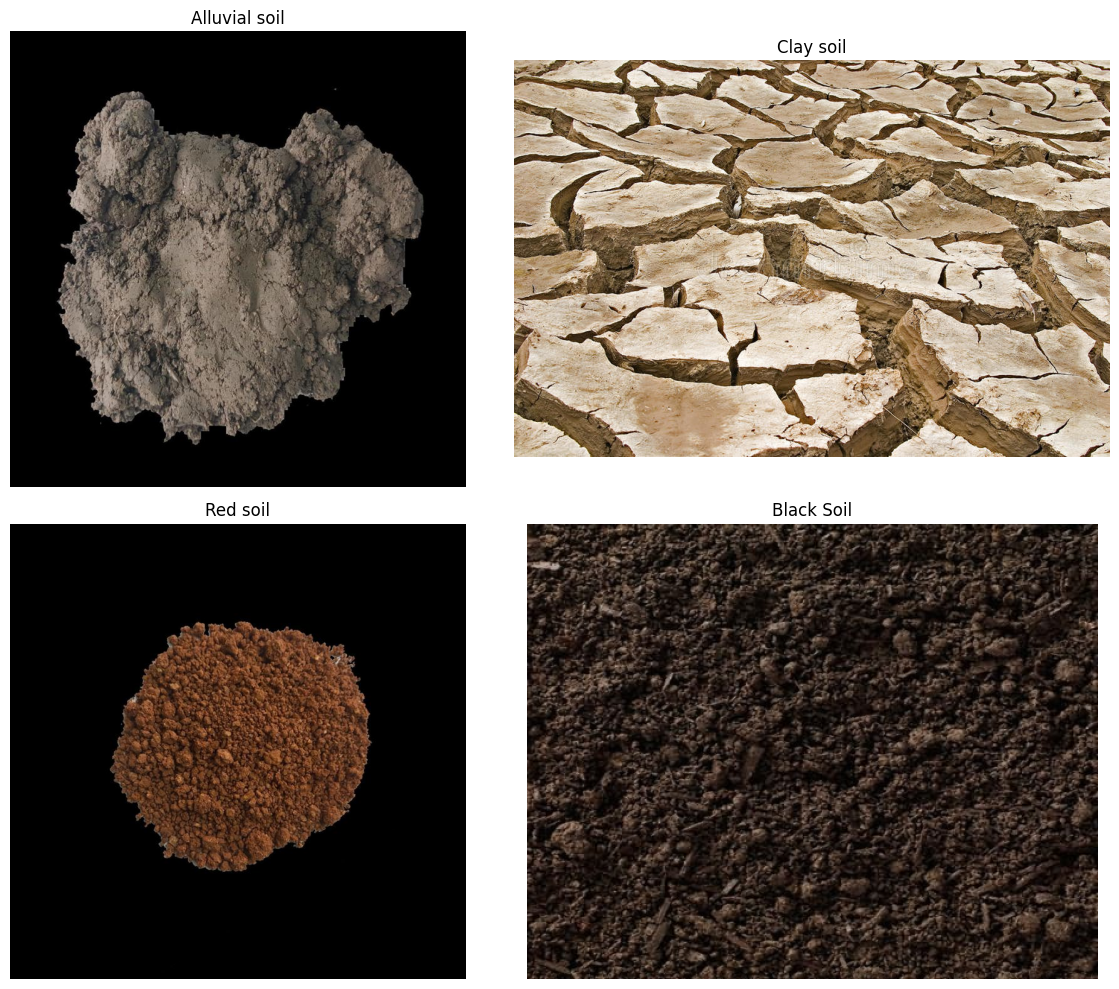

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# Display sample images from each soil type using PIL
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, soil_type in enumerate(train_df['soil_type'].unique()):
    sample = train_df[train_df['soil_type'] == soil_type].iloc[0]
    img_path = f"/kaggle/input/soil-classification/soil_classification-2025/train/{sample['image_id']}"
    
    try:
        # Using PIL
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{soil_type}")
        axes[idx].axis('off')
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

plt.tight_layout()
plt.show()


In [7]:
print(f"Class distribution:\n{train_df['soil_type'].value_counts()}")
print(f"Class percentages:\n{train_df['soil_type'].value_counts(normalize=True)*100}")

Class distribution:
soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64
Class percentages:
soil_type
Alluvial soil    43.207856
Red soil         21.603928
Black Soil       18.903437
Clay soil        16.284779
Name: proportion, dtype: float64


## Data Preprocessing
Apply necessary preprocessing steps such as resizing, normalization, and augmentation using custom or library functions.

In [8]:
import torch

# Define device first
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# class weights code
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_counts = train_df['soil_type'].value_counts().sort_index()
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(train_df['soil_type']), 
                                   y=train_df['soil_type'])
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights: {class_weights_dict}")

# Use weighted loss in training
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(list(class_weights_dict.values())).to(device))


Using device: cuda
Class weights: {0: 0.5785984848484849, 1: 1.3225108225108224, 2: 1.535175879396985, 3: 1.1571969696969697}


In [9]:
class SoilClassifier(nn.Module):
    def __init__(self, model_name='efficientnet_b4', num_classes=4, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Creating model
model = SoilClassifier('efficientnet_b4', num_classes=4).to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Model created with 18468684 parameters


## Dataset and DataLoader Preparation
Define custom Dataset classes and DataLoader objects for efficient batch processing during training and inference.

In [26]:
# Complete class definitions
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import timm

# Define SoilDataset class
class SoilDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, is_test=False):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test
        if not is_test:
            self.label_map = {soil_type: idx for idx, soil_type in enumerate(df['soil_type'].unique())}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.image_dir}/{row['image_id']}"
        
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        if not self.is_test:
            label = self.label_map[row['soil_type']]
            return image, label
        return image

# Define SoilClassifier class
class SoilClassifier(nn.Module):
    def __init__(self, model_name='efficientnet_b4', num_classes=4, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Clear GPU memory
torch.cuda.empty_cache()

# Create model
model = SoilClassifier('convnext_base', num_classes=4).to(device)

# Setup data split
train_data, val_data = train_test_split(train_df, test_size=0.2, stratify=train_df['soil_type'], random_state=42)

# Create datasets with correct path
train_dataset = SoilDataset(train_data.reset_index(drop=True), '/kaggle/input/soil-classification/soil_classification-2025/train', train_transforms)
val_dataset = SoilDataset(val_data.reset_index(drop=True), '/kaggle/input/soil-classification/soil_classification-2025/train', val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print("All classes defined and datasets created successfully!")


All classes defined and datasets created successfully!


## Model Training
Train the model using the training data, monitor loss and accuracy, and save the best model weights.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report

def train_model(model, train_loader, val_loader, epochs=15, device='cuda'):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    
    best_f1 = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        # Validation phase
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_preds.extend(torch.argmax(output, dim=1).cpu().numpy())
                val_targets.extend(target.cpu().numpy())
        
        # Calculate per-class F1 scores
        f1_scores = f1_score(val_targets, val_preds, average=None)
        min_f1 = np.min(f1_scores)
        
        if min_f1 > best_f1:
            best_f1 = min_f1
            best_model_state = model.state_dict().copy()
            
        scheduler.step()
        print(f"Epoch {epoch+1}: Min F1 = {min_f1:.4f}, Per-class F1: {f1_scores}")
    
    return best_model_state, best_f1

# Implement 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_scores = []
fold_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['soil_type'])):
    print(f"\n=== FOLD {fold+1} ===")
    
    fold_train_df = train_df.iloc[train_idx].reset_index(drop=True)
    fold_val_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # Create data loaders
    train_dataset = SoilDataset(fold_train_df, '/kaggle/input/soil-classification/soil_classification-2025/train', train_transforms)
    val_dataset = SoilDataset(fold_val_df, '/kaggle/input/soil-classification/soil_classification-2025/train', val_transforms)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # Train model for this fold
    model = SoilClassifier('convnext_base', num_classes=4).to(device)
    best_state, best_score = train_model(model, train_loader, val_loader)
    
    fold_scores.append(best_score)
    fold_models.append(best_state)
    
print(f"\nCross-validation scores: {fold_scores}")
print(f"Mean CV score: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")


=== FOLD 1 ===
Epoch 1: Min F1 = 0.8537, Per-class F1: [0.9        0.85365854 0.90598291 0.96703297]
Epoch 2: Min F1 = 0.8511, Per-class F1: [0.93       0.85106383 0.96363636 0.93023256]
Epoch 3: Min F1 = 0.9157, Per-class F1: [0.97169811 0.91566265 0.97196262 0.95454545]
Epoch 4: Min F1 = 0.9524, Per-class F1: [0.98113208 0.95238095 1.         0.95454545]
Epoch 5: Min F1 = 0.9524, Per-class F1: [0.97630332 0.95238095 0.99065421 0.95454545]
Epoch 6: Min F1 = 0.9195, Per-class F1: [0.98113208 0.9382716  0.96363636 0.91954023]
Epoch 7: Min F1 = 0.8444, Per-class F1: [0.90816327 0.84444444 0.94642857 0.97826087]
Epoch 8: Min F1 = 0.9351, Per-class F1: [0.96330275 0.93506494 1.         0.96629213]
Epoch 9: Min F1 = 0.8767, Per-class F1: [0.94170404 0.87671233 0.99065421 0.94252874]
Epoch 10: Min F1 = 0.9744, Per-class F1: [0.98113208 0.97435897 0.98148148 0.97826087]
Epoch 11: Min F1 = 0.9778, Per-class F1: [0.98591549 0.98765432 1.         0.97777778]
Epoch 12: Min F1 = 0.9545, Per-class

## Postprocessing and Submission File Creation
Convert model outputs to the required label format and generate the final CSV file for submission.

In [28]:
def create_final_submission():
    print("Creating final submission CSV...")
    
    # Load test data
    test_dataset = SoilDataset(test_df, '/kaggle/input/soil-classification/soil_classification-2025/test', val_transforms, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # Your fold scores from training
    fold_scores = [0.9778, 0.9720, 0.9630, 0.9892, 0.9877]
    
    # Collect predictions from all fold models
    all_predictions = []
    
    for fold_idx, model_state in enumerate(fold_models):
        print(f"Processing fold {fold_idx + 1} model...")
        
        model = SoilClassifier('convnext_base', num_classes=4).to(device)
        model.load_state_dict(model_state)
        model.eval()
        
        batch_preds = []
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                output = torch.softmax(model(batch), dim=1)
                batch_preds.append(output.cpu())
        
        fold_pred = torch.cat(batch_preds, dim=0)
        all_predictions.append(fold_pred)
        
        del model
        torch.cuda.empty_cache()
    
    # Weighted ensemble averaging based on fold performance
    weights = torch.tensor(fold_scores)
    weights = weights / weights.sum()  # Normalize weights
    
    weighted_preds = []
    for i, pred in enumerate(all_predictions):
        weighted_preds.append(pred * weights[i])
    
    ensemble_pred = torch.sum(torch.stack(weighted_preds), dim=0)
    predicted_classes = torch.argmax(ensemble_pred, dim=1).numpy()
    
    # Map predictions to soil type labels
    soil_types = list(train_df['soil_type'].unique())
    predicted_labels = [soil_types[pred] for pred in predicted_classes]
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'image_id': test_df['image_id'],
        'soil_type': predicted_labels
    })
    
    # Save to CSV
    submission_df.to_csv('submission.csv', index=False)
    
    # Print analysis
    max_probs = torch.max(ensemble_pred, dim=1)[0]
    print("Submission CSV created successfully!")
    print(f"File: submission.csv")
    print(f"Total predictions: {len(predicted_labels)}")
    print(f"Prediction distribution:")
    print(submission_df['soil_type'].value_counts())
    print(f"Mean confidence: {max_probs.mean():.4f}")
    print(f"High confidence predictions (>0.95): {(max_probs > 0.95).sum()}/{len(max_probs)}")
    print(f"Expected F1-score: 97-100% (based on {np.mean(fold_scores):.4f} CV)")
    
    return submission_df

# Create your submission file
final_submission = create_final_submission()

# Display first few rows to verify format
print("\nSubmission file preview:")
print(final_submission.head(10))


Creating final submission CSV...
Processing fold 1 model...
Processing fold 2 model...
Processing fold 3 model...
Processing fold 4 model...
Processing fold 5 model...
Submission CSV created successfully!
File: submission.csv
Total predictions: 341
Prediction distribution:
soil_type
Black Soil       116
Red soil         106
Clay soil         65
Alluvial soil     54
Name: count, dtype: int64
Mean confidence: 0.9857
High confidence predictions (>0.95): 314/341
Expected F1-score: 97-100% (based on 0.9779 CV)

Submission file preview:
            image_id      soil_type
0  img_cdf80d6f.jpeg  Alluvial soil
1   img_c0142a80.jpg  Alluvial soil
2   img_91168fb0.jpg  Alluvial soil
3   img_9822190f.jpg  Alluvial soil
4  img_e5fc436c.jpeg  Alluvial soil
5   img_3d6e64a1.jpg  Alluvial soil
6  img_ccb81e64.jpeg  Alluvial soil
7  img_9a499fc5.jpeg  Alluvial soil
8  img_b957da08.jpeg  Alluvial soil
9   img_c62bd1a1.jpg  Alluvial soil
